ЗАПУСК СТРАТЕГИИ ПАРНОГО АРБИТРАЖА
Пара: NEARUSDT - DOTUSDT
Период: 2025-01-01 - 2025-01-15
Таймфрейм: 5m
Начальный капитал: 10000 USDT
Кредитное плечо: 1x
Загрузка данных для парного трейдинга...
Пара: NEARUSDT - DOTUSDT
Период: 2025-01-01 - 2025-01-15
Таймфрейм: 5m
Получение данных для NEARUSDT...
  Загружено 4033 свечек для NEARUSDT
  Период: 2025-01-01 03:00:00 - 2025-01-15 03:00:00
Получение данных для DOTUSDT...
  Загружено 4033 свечек для DOTUSDT
  Период: 2025-01-01 03:00:00 - 2025-01-15 03:00:00

Данные успешно загружены
Количество наблюдений: 4033
Период данных: 2025-01-01 03:00:00 - 2025-01-15 03:00:00

Расчет торговых сигналов...
Сигналы рассчитаны для 3842 периодов
Средняя бета: 0.693943
Стд. откл. беты: 0.219203

Запуск бэктестирования...

Бэктестирование завершено
Количество сделок: 35

=== МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ ===

ОБЩИЕ МЕТРИКИ:
Начальный капитал: 10,000.00 USDT
Конечный капитал: 10,264.91 USDT
Общая доходность: 2.65%
Максимальная просадка: -3.87%
Коэффициент Шар

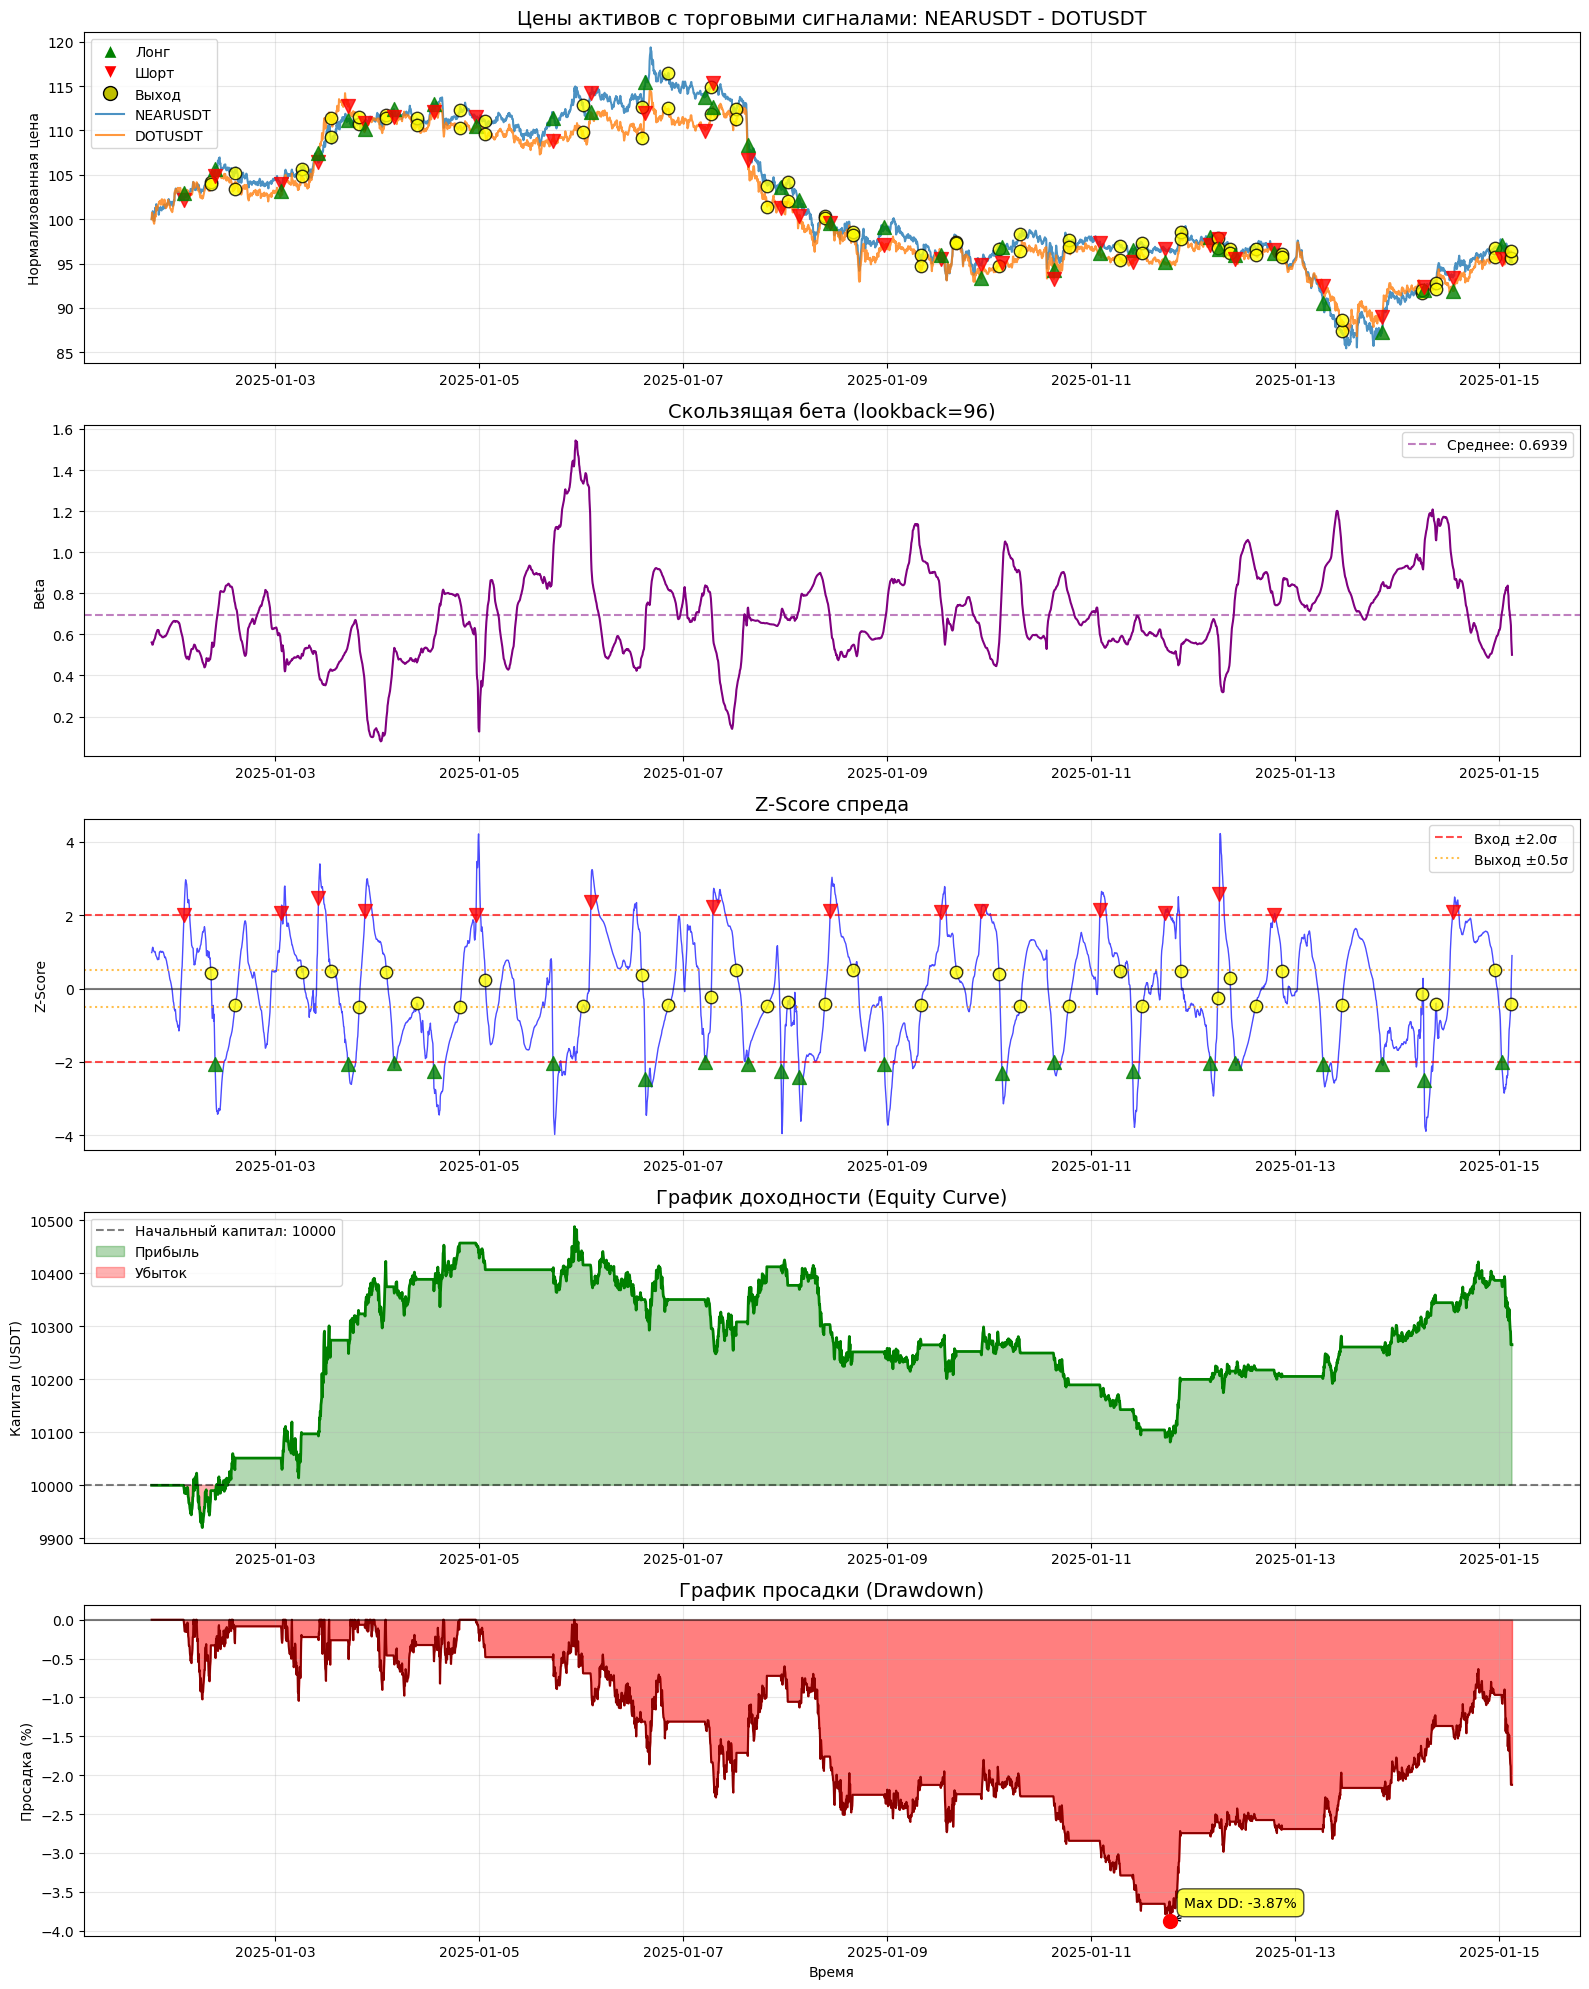

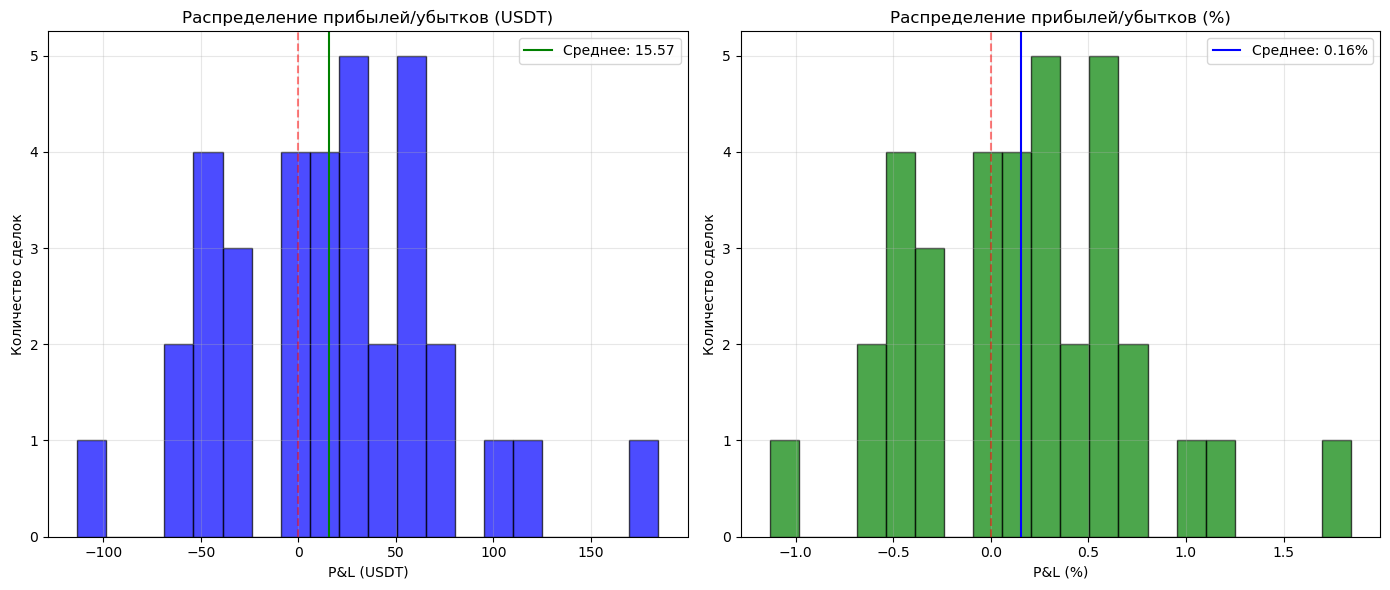


Стратегия выполнена успешно!


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from binance.client import Client
from datetime import datetime, timedelta
import time
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# НАСТРОЙКИ СТРАТЕГИИ
# =============================================================================

# Временные параметры
START_DATE = '2025-01-01'          # Начальная дата анализа
END_DATE = '2025-01-15'            # Конечная дата анализа
TIMEFRAME = '5m'                   # Таймфрейм данных

# Торговые пары
ASSET1 = 'NEARUSDT'               # Первый актив
ASSET2 = 'DOTUSDT'                # Второй актив

# Капитал и риск-менеджмент
INITIAL_CAPITAL = 10000           # Начальный капитал в USDT
LEVERAGE = 1                      # Кредитное плечо
TRADING_CAPITAL = INITIAL_CAPITAL * LEVERAGE  # Торговый капитал
COMMISSION_RATE = 0.0002          # Комиссия за сделку (0.02%)

# Параметры стратегии
LOOKBACK_PERIOD = 96              # Период для расчета скользящей беты и Z-Score (96 = 8 часов на 5м)
ENTRY_THRESHOLD = 2.0             # Z-Score для входа в позицию
EXIT_THRESHOLD = 0.5              # Z-Score для выхода из позиции
MIN_HOLDING_PERIODS = 4           # Минимальное время удержания позиции (4 периода = 20 минут)

# Параметры API
API_DELAY = 0.2                   # Задержка между запросами к API (секунды)
KLINES_LIMIT = 1000               # Максимум свечек за один запрос

# =============================================================================

class PairsTradingStrategy:
    def __init__(self):
        """
        Инициализация стратегии парного трейдинга
        """
        # Клиент Binance (публичный API, ключи не требуются для получения данных)
        self.client = Client()
        
        # Данные
        self.asset1_data = None
        self.asset2_data = None
        self.prices_df = None
        
        # Результаты бэктестирования
        self.trades = []
        self.portfolio_value = []
        self.positions = []
        
    def fetch_futures_data(self, symbol, start_date=START_DATE, end_date=END_DATE, interval=TIMEFRAME):
        """
        Получение данных фьючерсов с Binance
        """
        try:
            print(f"Получение данных для {symbol}...")
            
            # Преобразование дат в миллисекунды
            start_ts = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
            end_ts = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)
            
            all_klines = []
            current_start = start_ts
            
            while current_start < end_ts:
                # Получение данных
                klines = self.client.futures_klines(
                    symbol=symbol,
                    interval=interval,
                    startTime=current_start,
                    endTime=end_ts,
                    limit=KLINES_LIMIT
                )
                
                if not klines:
                    break
                
                all_klines.extend(klines)
                
                # Обновляем начальную точку
                last_timestamp = int(klines[-1][0])
                interval_ms = 5 * 60 * 1000  # 5 минут в миллисекундах
                current_start = last_timestamp + interval_ms
                
                # Пауза между запросами
                time.sleep(API_DELAY)
                
                if current_start >= end_ts:
                    break
            
            if not all_klines:
                print(f"Нет данных для {symbol}")
                return None
            
            # Преобразование в DataFrame
            df = pd.DataFrame(all_klines, columns=[
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
            ])
            
            # Обработка данных
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            
            # Конвертация в числовые значения
            numeric_columns = ['open', 'high', 'low', 'close', 'volume']
            df[numeric_columns] = df[numeric_columns].astype(float)
            
            # Удаление дубликатов и сортировка
            df = df[~df.index.duplicated(keep='first')]
            df = df.sort_index()
            
            print(f"  Загружено {len(df)} свечек для {symbol}")
            print(f"  Период: {df.index[0]} - {df.index[-1]}")
            
            return df
            
        except Exception as e:
            print(f"Ошибка при получении данных для {symbol}: {e}")
            return None
    
    def load_data(self):
        """
        Загрузка данных для обоих активов
        """
        print("Загрузка данных для парного трейдинга...")
        print(f"Пара: {ASSET1} - {ASSET2}")
        print(f"Период: {START_DATE} - {END_DATE}")
        print(f"Таймфрейм: {TIMEFRAME}")
        
        # Загрузка данных
        self.asset1_data = self.fetch_futures_data(ASSET1)
        self.asset2_data = self.fetch_futures_data(ASSET2)
        
        if self.asset1_data is None or self.asset2_data is None:
            raise ValueError("Не удалось загрузить данные для одного или обоих активов")
        
        # Создание общего DataFrame
        self.prices_df = pd.DataFrame({
            ASSET1: self.asset1_data['close'],
            ASSET2: self.asset2_data['close']
        })
        
        # Удаление пропущенных значений
        self.prices_df.dropna(inplace=True)
        
        print(f"\nДанные успешно загружены")
        print(f"Количество наблюдений: {len(self.prices_df)}")
        print(f"Период данных: {self.prices_df.index[0]} - {self.prices_df.index[-1]}")
    
    def calculate_rolling_beta(self, asset1_prices, asset2_prices, lookback_period):
        """
        Расчет скользящей беты с использованием линейной регрессии
        """
        betas = []
        
        for i in range(lookback_period, len(asset1_prices)):
            # Берем окно данных
            y = asset1_prices.iloc[i-lookback_period:i].values
            X = asset2_prices.iloc[i-lookback_period:i].values.reshape(-1, 1)
            
            # Линейная регрессия
            reg = LinearRegression().fit(X, y)
            betas.append(reg.coef_[0])
        
        # Создаем Series с правильным индексом
        beta_series = pd.Series(betas, index=asset1_prices.index[lookback_period:])
        
        return beta_series
    
    def calculate_signals(self):
        """
        Расчет торговых сигналов на основе Z-Score спреда
        """
        print("\nРасчет торговых сигналов...")
        
        # Получение цен
        asset1_prices = self.prices_df[ASSET1]
        asset2_prices = self.prices_df[ASSET2]
        
        # Расчет скользящей беты
        rolling_beta = self.calculate_rolling_beta(asset1_prices, asset2_prices, LOOKBACK_PERIOD)
        
        # Расчет спреда со скользящей бетой
        common_index = rolling_beta.index
        spread = asset1_prices.loc[common_index] - rolling_beta * asset2_prices.loc[common_index]
        
        # Расчет Z-Score
        spread_mean = spread.rolling(LOOKBACK_PERIOD).mean()
        spread_std = spread.rolling(LOOKBACK_PERIOD).std()
        spread_zscore = (spread - spread_mean) / spread_std
        
        # Удаляем NaN значения
        spread_zscore = spread_zscore.dropna()
        
        # Сохранение результатов
        self.spread = spread.loc[spread_zscore.index]
        self.spread_zscore = spread_zscore
        self.rolling_beta = rolling_beta.loc[spread_zscore.index]
        
        print(f"Сигналы рассчитаны для {len(self.spread_zscore)} периодов")
        print(f"Средняя бета: {self.rolling_beta.mean():.6f}")
        print(f"Стд. откл. беты: {self.rolling_beta.std():.6f}")
    
    def backtest(self):
        """
        Бэктестирование стратегии
        """
        print("\nЗапуск бэктестирования...")
        
        # Инициализация
        capital = INITIAL_CAPITAL
        position = 0  # 0 - нет позиции, 1 - лонг спред, -1 - шорт спред
        periods_in_position = 0
        entry_price1 = 0
        entry_price2 = 0
        entry_beta = 0
        
        # История
        equity_curve = []
        drawdown_curve = []
        max_equity = INITIAL_CAPITAL
        
        # Получаем общий индекс
        common_index = self.spread_zscore.index
        asset1_prices = self.prices_df[ASSET1].loc[common_index]
        asset2_prices = self.prices_df[ASSET2].loc[common_index]
        
        for i in range(len(self.spread_zscore)):
            current_time = self.spread_zscore.index[i]
            current_zscore = self.spread_zscore.iloc[i]
            current_beta = self.rolling_beta.iloc[i]
            current_price1 = asset1_prices.iloc[i]
            current_price2 = asset2_prices.iloc[i]
            
            # Логика входа и выхода
            if position == 0:  # Нет позиции
                if current_zscore > ENTRY_THRESHOLD:  # Спред высокий - шорт спред
                    # Шорт ASSET1, Лонг ASSET2
                    position = -1
                    periods_in_position = 0
                    entry_price1 = current_price1
                    entry_price2 = current_price2
                    entry_beta = current_beta
                    
                    # Расчет позиций с учетом беты
                    # Распределяем капитал пропорционально бете
                    total_value = TRADING_CAPITAL
                    asset2_value = total_value / (1 + current_beta)
                    asset1_value = total_value - asset2_value
                    
                    position_size1 = asset1_value / current_price1
                    position_size2 = asset2_value / current_price2
                    
                    # Комиссия за вход
                    commission = TRADING_CAPITAL * COMMISSION_RATE * 2  # За оба актива
                    capital -= commission
                    
                    self.trades.append({
                        'entry_time': current_time,
                        'type': 'SHORT_SPREAD',
                        'entry_price1': entry_price1,
                        'entry_price2': entry_price2,
                        'entry_beta': entry_beta,
                        'entry_zscore': current_zscore,
                        'position_size1': position_size1,
                        'position_size2': position_size2,
                        'direction1': 'SHORT',
                        'direction2': 'LONG'
                    })
                    
                elif current_zscore < -ENTRY_THRESHOLD:  # Спред низкий - лонг спред
                    # Лонг ASSET1, Шорт ASSET2
                    position = 1
                    periods_in_position = 0
                    entry_price1 = current_price1
                    entry_price2 = current_price2
                    entry_beta = current_beta
                    
                    # Расчет позиций
                    total_value = TRADING_CAPITAL
                    asset2_value = total_value / (1 + current_beta)
                    asset1_value = total_value - asset2_value
                    
                    position_size1 = asset1_value / current_price1
                    position_size2 = asset2_value / current_price2
                    
                    # Комиссия за вход
                    commission = TRADING_CAPITAL * COMMISSION_RATE * 2
                    capital -= commission
                    
                    self.trades.append({
                        'entry_time': current_time,
                        'type': 'LONG_SPREAD',
                        'entry_price1': entry_price1,
                        'entry_price2': entry_price2,
                        'entry_beta': entry_beta,
                        'entry_zscore': current_zscore,
                        'position_size1': position_size1,
                        'position_size2': position_size2,
                        'direction1': 'LONG',
                        'direction2': 'SHORT'
                    })
            
            elif position != 0:  # Есть позиция
                periods_in_position += 1
                
                # Расчет текущей прибыли/убытка
                if position == 1:  # Лонг спред
                    # Прибыль от лонга ASSET1
                    pnl1 = self.trades[-1]['position_size1'] * (current_price1 - entry_price1)
                    # Прибыль от шорта ASSET2
                    pnl2 = self.trades[-1]['position_size2'] * (entry_price2 - current_price2)
                else:  # Шорт спред
                    # Прибыль от шорта ASSET1
                    pnl1 = self.trades[-1]['position_size1'] * (entry_price1 - current_price1)
                    # Прибыль от лонга ASSET2
                    pnl2 = self.trades[-1]['position_size2'] * (current_price2 - entry_price2)
                
                total_pnl = pnl1 + pnl2
                
                # Выход из позиции
                if periods_in_position >= MIN_HOLDING_PERIODS and abs(current_zscore) < EXIT_THRESHOLD:
                    # Комиссия за выход
                    commission = TRADING_CAPITAL * COMMISSION_RATE * 2
                    capital = capital + total_pnl - commission
                    
                    # Сохранение информации о сделке
                    self.trades[-1].update({
                        'exit_time': current_time,
                        'exit_price1': current_price1,
                        'exit_price2': current_price2,
                        'exit_zscore': current_zscore,
                        'pnl': total_pnl,
                        'pnl_percent': (total_pnl / TRADING_CAPITAL) * 100,
                        'holding_periods': periods_in_position,
                        'commission_total': TRADING_CAPITAL * COMMISSION_RATE * 4  # Вход + выход
                    })
                    
                    position = 0
                    periods_in_position = 0
            
            # Обновление equity
            current_equity = capital
            if position != 0:
                # Добавляем нереализованную прибыль
                if position == 1:
                    unrealized_pnl1 = self.trades[-1]['position_size1'] * (current_price1 - entry_price1)
                    unrealized_pnl2 = self.trades[-1]['position_size2'] * (entry_price2 - current_price2)
                else:
                    unrealized_pnl1 = self.trades[-1]['position_size1'] * (entry_price1 - current_price1)
                    unrealized_pnl2 = self.trades[-1]['position_size2'] * (current_price2 - entry_price2)
                current_equity += unrealized_pnl1 + unrealized_pnl2
            
            equity_curve.append(current_equity)
            
            # Расчет просадки
            if current_equity > max_equity:
                max_equity = current_equity
            drawdown = (current_equity - max_equity) / max_equity * 100
            drawdown_curve.append(drawdown)
            
            # Сохранение позиций для визуализации
            self.positions.append({
                'time': current_time,
                'position': position,
                'equity': current_equity,
                'drawdown': drawdown
            })
        
        # Сохранение результатов
        self.equity_curve = pd.Series(equity_curve, index=common_index)
        self.drawdown_curve = pd.Series(drawdown_curve, index=common_index)
        
        print(f"\nБэктестирование завершено")
        print(f"Количество сделок: {len([t for t in self.trades if 'exit_time' in t])}")
    
    def calculate_metrics(self):
        """
        Расчет метрик производительности
        """
        print("\n=== МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ ===")
        
        # Фильтруем только закрытые сделки
        closed_trades = [t for t in self.trades if 'exit_time' in t]
        
        if len(closed_trades) == 0:
            print("Нет закрытых сделок для анализа")
            return
        
        # Основные метрики
        total_return = (self.equity_curve.iloc[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100
        max_drawdown = self.drawdown_curve.min()
        
        # Метрики по сделкам
        profits = [t['pnl'] for t in closed_trades]
        profit_percents = [t['pnl_percent'] for t in closed_trades]
        
        winning_trades = [p for p in profits if p > 0]
        losing_trades = [p for p in profits if p < 0]
        
        win_rate = len(winning_trades) / len(closed_trades) * 100 if closed_trades else 0
        
        avg_profit = np.mean(profits) if profits else 0
        avg_profit_percent = np.mean(profit_percents) if profit_percents else 0
        
        avg_win = np.mean(winning_trades) if winning_trades else 0
        avg_loss = np.mean(losing_trades) if losing_trades else 0
        
        # Profit Factor
        total_wins = sum(winning_trades) if winning_trades else 0
        total_losses = abs(sum(losing_trades)) if losing_trades else 1
        profit_factor = total_wins / total_losses if total_losses > 0 else 0
        
        # Sharpe Ratio (annualized)
        returns = self.equity_curve.pct_change().dropna()
        periods_per_year = 365 * 24 * 12  # 5-минутные периоды в году
        sharpe_ratio = np.sqrt(periods_per_year) * returns.mean() / returns.std() if returns.std() > 0 else 0
        
        # Среднее время удержания позиции
        holding_times = [t['holding_periods'] for t in closed_trades]
        avg_holding_time = np.mean(holding_times) if holding_times else 0
        
        # Вывод метрик
        print(f"\nОБЩИЕ МЕТРИКИ:")
        print(f"Начальный капитал: {INITIAL_CAPITAL:,.2f} USDT")
        print(f"Конечный капитал: {self.equity_curve.iloc[-1]:,.2f} USDT")
        print(f"Общая доходность: {total_return:.2f}%")
        print(f"Максимальная просадка: {max_drawdown:.2f}%")
        print(f"Коэффициент Шарпа: {sharpe_ratio:.2f}")
        
        print(f"\nМЕТРИКИ СДЕЛОК:")
        print(f"Всего сделок: {len(closed_trades)}")
        print(f"Прибыльных сделок: {len(winning_trades)}")
        print(f"Убыточных сделок: {len(losing_trades)}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Profit Factor: {profit_factor:.2f}")
        
        print(f"\nСРЕДНИЕ ПОКАЗАТЕЛИ:")
        print(f"Средняя прибыль на сделку: {avg_profit:.2f} USDT ({avg_profit_percent:.2f}%)")
        print(f"Средняя прибыльная сделка: {avg_win:.2f} USDT")
        print(f"Средняя убыточная сделка: {avg_loss:.2f} USDT")
        print(f"Среднее время удержания: {avg_holding_time:.1f} периодов ({avg_holding_time * 5:.0f} минут)")
        
        print(f"\nТОРГОВЫЕ ПАРАМЕТРЫ:")
        print(f"Кредитное плечо: {LEVERAGE}x")
        print(f"Торговый капитал: {TRADING_CAPITAL:,.2f} USDT")
        print(f"Комиссия: {COMMISSION_RATE * 100:.2f}%")
        
        # Детали по типам сделок
        long_spread_trades = [t for t in closed_trades if t['type'] == 'LONG_SPREAD']
        short_spread_trades = [t for t in closed_trades if t['type'] == 'SHORT_SPREAD']
        
        print(f"\nДЕТАЛИ ПО ТИПАМ СДЕЛОК:")
        print(f"Лонг спред сделок: {len(long_spread_trades)}")
        print(f"Шорт спред сделок: {len(short_spread_trades)}")
    
    def plot_results(self):
        """
        Визуализация результатов бэктестирования
        """
        print("\nСоздание визуализаций...")
        
        # Подготовка данных
        common_index = self.spread_zscore.index
        asset1_prices = self.prices_df[ASSET1].loc[common_index]
        asset2_prices = self.prices_df[ASSET2].loc[common_index]
        
        # Создание фигуры с подграфиками
        fig = plt.figure(figsize=(16, 20))
        
        # 1. График цен активов с сигналами
        ax1 = plt.subplot(5, 1, 1)
        
        # Нормализация цен для визуализации
        price1_norm = (asset1_prices / asset1_prices.iloc[0]) * 100
        price2_norm = (asset2_prices / asset2_prices.iloc[0]) * 100
        
        ax1.plot(price1_norm.index, price1_norm, label=ASSET1, linewidth=1.5, alpha=0.8)
        ax1.plot(price2_norm.index, price2_norm, label=ASSET2, linewidth=1.5, alpha=0.8)
        
        # Отображение сигналов входа и выхода
        for trade in self.trades:
            if 'exit_time' not in trade:
                continue
                
            # Вход в сделку
            entry_idx = price1_norm.index.get_loc(trade['entry_time'])
            if trade['type'] == 'LONG_SPREAD':
                ax1.scatter(trade['entry_time'], price1_norm.iloc[entry_idx], 
                          color='green', marker='^', s=100, alpha=0.8, zorder=5)
                ax1.scatter(trade['entry_time'], price2_norm.iloc[entry_idx], 
                          color='red', marker='v', s=100, alpha=0.8, zorder=5)
            else:  # SHORT_SPREAD
                ax1.scatter(trade['entry_time'], price1_norm.iloc[entry_idx], 
                          color='red', marker='v', s=100, alpha=0.8, zorder=5)
                ax1.scatter(trade['entry_time'], price2_norm.iloc[entry_idx], 
                          color='green', marker='^', s=100, alpha=0.8, zorder=5)
            
            # Выход из сделки
            exit_idx = price1_norm.index.get_loc(trade['exit_time'])
            ax1.scatter(trade['exit_time'], price1_norm.iloc[exit_idx], 
                      color='yellow', marker='o', s=80, alpha=0.8, edgecolors='black', zorder=5)
            ax1.scatter(trade['exit_time'], price2_norm.iloc[exit_idx], 
                      color='yellow', marker='o', s=80, alpha=0.8, edgecolors='black', zorder=5)
        
        ax1.set_title(f'Цены активов с торговыми сигналами: {ASSET1} - {ASSET2}', fontsize=14)
        ax1.set_ylabel('Нормализованная цена')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Добавление легенды для сигналов
        from matplotlib.lines import Line2D
        custom_lines = [
            Line2D([0], [0], marker='^', color='w', markerfacecolor='g', markersize=10),
            Line2D([0], [0], marker='v', color='w', markerfacecolor='r', markersize=10),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='y', 
                  markeredgecolor='black', markersize=10)
        ]
        ax1.legend(custom_lines + ax1.get_lines()[:2], 
                  ['Лонг', 'Шорт', 'Выход', ASSET1, ASSET2], 
                  loc='upper left')
        
        # 2. Скользящая бета
        ax2 = plt.subplot(5, 1, 2)
        ax2.plot(self.rolling_beta.index, self.rolling_beta, linewidth=1.5, color='purple')
        ax2.axhline(y=self.rolling_beta.mean(), color='purple', linestyle='--', alpha=0.5, 
                   label=f'Среднее: {self.rolling_beta.mean():.4f}')
        ax2.set_title(f'Скользящая бета (lookback={LOOKBACK_PERIOD})', fontsize=14)
        ax2.set_ylabel('Beta')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Z-Score спреда
        ax3 = plt.subplot(5, 1, 3)
        ax3.plot(self.spread_zscore.index, self.spread_zscore, linewidth=1, alpha=0.7, color='blue')
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax3.axhline(y=ENTRY_THRESHOLD, color='red', linestyle='--', alpha=0.7, 
                   label=f'Вход ±{ENTRY_THRESHOLD}σ')
        ax3.axhline(y=-ENTRY_THRESHOLD, color='red', linestyle='--', alpha=0.7)
        ax3.axhline(y=EXIT_THRESHOLD, color='orange', linestyle=':', alpha=0.7, 
                   label=f'Выход ±{EXIT_THRESHOLD}σ')
        ax3.axhline(y=-EXIT_THRESHOLD, color='orange', linestyle=':', alpha=0.7)
        
        # Отображение точек входа и выхода
        for trade in self.trades:
            if 'exit_time' not in trade:
                continue
            
            # Вход
            entry_idx = self.spread_zscore.index.get_loc(trade['entry_time'])
            ax3.scatter(trade['entry_time'], trade['entry_zscore'], 
                      color='green' if trade['type'] == 'LONG_SPREAD' else 'red', 
                      marker='^' if trade['type'] == 'LONG_SPREAD' else 'v', 
                      s=100, alpha=0.8, zorder=5)
            
            # Выход
            exit_idx = self.spread_zscore.index.get_loc(trade['exit_time'])
            ax3.scatter(trade['exit_time'], trade['exit_zscore'], 
                      color='yellow', marker='o', s=80, alpha=0.8, 
                      edgecolors='black', zorder=5)
        
        ax3.set_title(f'Z-Score спреда', fontsize=14)
        ax3.set_ylabel('Z-Score')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. График доходности (Equity Curve)
        ax4 = plt.subplot(5, 1, 4)
        ax4.plot(self.equity_curve.index, self.equity_curve, linewidth=2, color='green')
        ax4.axhline(y=INITIAL_CAPITAL, color='black', linestyle='--', alpha=0.5, 
                   label=f'Начальный капитал: {INITIAL_CAPITAL}')
        ax4.fill_between(self.equity_curve.index, INITIAL_CAPITAL, self.equity_curve, 
                        where=(self.equity_curve >= INITIAL_CAPITAL), 
                        color='green', alpha=0.3, label='Прибыль')
        ax4.fill_between(self.equity_curve.index, INITIAL_CAPITAL, self.equity_curve, 
                        where=(self.equity_curve < INITIAL_CAPITAL), 
                        color='red', alpha=0.3, label='Убыток')
        
        ax4.set_title('График доходности (Equity Curve)', fontsize=14)
        ax4.set_ylabel('Капитал (USDT)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. График просадки (Drawdown)
        ax5 = plt.subplot(5, 1, 5)
        ax5.fill_between(self.drawdown_curve.index, 0, self.drawdown_curve, 
                        color='red', alpha=0.5)
        ax5.plot(self.drawdown_curve.index, self.drawdown_curve, 
                linewidth=1.5, color='darkred')
        ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Отметка максимальной просадки
        max_dd = self.drawdown_curve.min()
        max_dd_idx = self.drawdown_curve.idxmin()
        ax5.scatter(max_dd_idx, max_dd, color='red', s=100, zorder=5)
        ax5.annotate(f'Max DD: {max_dd:.2f}%', 
                    xy=(max_dd_idx, max_dd), 
                    xytext=(10, 10), 
                    textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        ax5.set_title('График просадки (Drawdown)', fontsize=14)
        ax5.set_ylabel('Просадка (%)')
        ax5.set_xlabel('Время')
        ax5.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Дополнительная визуализация: распределение прибылей/убытков
        if self.trades and any('pnl' in t for t in self.trades):
            fig2, (ax6, ax7) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Гистограмма P&L
            closed_trades = [t for t in self.trades if 'exit_time' in t]
            pnls = [t['pnl'] for t in closed_trades]
            pnl_percents = [t['pnl_percent'] for t in closed_trades]
            
            ax6.hist(pnls, bins=20, alpha=0.7, color='blue', edgecolor='black')
            ax6.axvline(x=0, color='red', linestyle='--', alpha=0.5)
            ax6.axvline(x=np.mean(pnls), color='green', linestyle='-', 
                       label=f'Среднее: {np.mean(pnls):.2f}')
            ax6.set_title('Распределение прибылей/убытков (USDT)')
            ax6.set_xlabel('P&L (USDT)')
            ax6.set_ylabel('Количество сделок')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
            
            # Гистограмма P&L в процентах
            ax7.hist(pnl_percents, bins=20, alpha=0.7, color='green', edgecolor='black')
            ax7.axvline(x=0, color='red', linestyle='--', alpha=0.5)
            ax7.axvline(x=np.mean(pnl_percents), color='blue', linestyle='-', 
                       label=f'Среднее: {np.mean(pnl_percents):.2f}%')
            ax7.set_title('Распределение прибылей/убытков (%)')
            ax7.set_xlabel('P&L (%)')
            ax7.set_ylabel('Количество сделок')
            ax7.legend()
            ax7.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    def run_strategy(self):
        """
        Запуск полной стратегии
        """
        print("=" * 60)
        print("ЗАПУСК СТРАТЕГИИ ПАРНОГО АРБИТРАЖА")
        print("=" * 60)
        print(f"Пара: {ASSET1} - {ASSET2}")
        print(f"Период: {START_DATE} - {END_DATE}")
        print(f"Таймфрейм: {TIMEFRAME}")
        print(f"Начальный капитал: {INITIAL_CAPITAL} USDT")
        print(f"Кредитное плечо: {LEVERAGE}x")
        print("=" * 60)
        
        try:
            # 1. Загрузка данных
            self.load_data()
            
            # 2. Расчет сигналов
            self.calculate_signals()
            
            # 3. Бэктестирование
            self.backtest()
            
            # 4. Расчет метрик
            self.calculate_metrics()
            
            # 5. Визуализация
            self.plot_results()
            
            print("\nСтратегия выполнена успешно!")
            
        except Exception as e:
            print(f"\nОшибка при выполнении стратегии: {e}")
            import traceback
            traceback.print_exc()


# Запуск стратегии
if __name__ == "__main__":
    strategy = PairsTradingStrategy()
    strategy.run_strategy()